In [1]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField, StringType,FloatType, 
                               DoubleType, IntegerType, StructType,
                              DateType)
from pyspark.sql import functions as F
from pyspark.sql import DataFrame as spDataFrame


from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (Binarizer, OneHotEncoder, StringIndexer, HashingTF, 
                                Tokenizer, StandardScaler, VectorAssembler,
                               OneHotEncoder, StringIndexer, VectorIndexer)
from pyspark.ml.classification import LogisticRegression, LinearSVC, LinearSVCModel
from pyspark.ml.evaluation import HasFeaturesCol
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import chi2, RFECV, SelectKBest
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import parallel_backend

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import xgboost as xgb
import plotly
#import luminol
import plotly.plotly as py
import plotly.graph_objs as go

from fbprophet import Prophet

#from tokenizer import Tokenizer

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


In [3]:
plotly.tools.set_credentials_file(username='smillett', api_key='MXYpm8AMvEte7SSw6dKu')

This is to setup the sparksession. If additional resources need to be allocated it is done with this command

# Import CSV Data

In [199]:
#import dataset
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_5m_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 200.26840090751648 seconds ---


# Data cleaning

In [200]:
#replace all missing values with 0
master_df = master_df.replace(-999, 0)
master_df['time']=pd.to_datetime(master_df['time'])

In [202]:
resampled_df = master_df.groupby('time').agg({'redteam_event':'sum',
                                               'dns_count':'mean',
                                               'newresolved_count':'mean',
                                               'fail_count':'mean',
                                               'LoggedOn':'mean',
                                               'dur':'mean',
                                               'pkt_cnt':'mean',
                                               'byte_cnt':'mean',
                                               'avg_pkt_size':'mean',
                                               'proc_total':'mean',
                                               'proc_exec_total':'mean',
                                               'newexecute_count':'mean',
                                               'Proc_run':'mean'} )
resampled_df.index = pd.to_datetime(resampled_df.index)
resampled_df['redteam_event'] = resampled_df.redteam_event.map(lambda x: 1 if x > 0 else x)
#redteam_events = resampled_df[resampled_df['redteam_event']>0].index

In [193]:
m=Prophet()


prophet_test = pd.DataFrame({'ds':resampled_df.index,'y':resampled_df.LoggedOn})
m.fit(prophet_test)
future=m.make_future_dataframe(periods=0)
forecast=m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [219]:
new_value = prophet_test['y'].values-forecast['yhat'].values

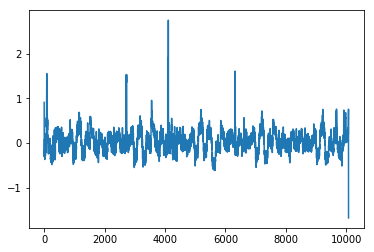

In [180]:
ds = resampled_df['redteam_event']
ds = ds.map({0:False, 1:True})
def get_delay(ds):
    x1 = (~ds).cumsum()
    x2 = x1.where(ds, np.nan).ffill()
    return x1 - x2

ds = get_delay(ds).replace(np.nan,0)
#ds = ds.map({False:0, True:1})
resampled_df['last_redteam_event'] = ds

In [197]:
master_df = master_df.merge(resampled_df.reset_index(), on='time',how='left', suffixes=('_single','_total'))

# Basic stats on dataset

In [ ]:
master_df.head()

In [5]:
master_df.shape

(129295890, 15)

In [61]:
master_df[['src_comp','redteam_event']].groupby('redteam_event').count()

,src_comp
redteam_event,
0.0,129295559
1.0,331


In [191]:
master_df['src_comp'].nunique()

15383

In [11]:
#remove daily variance

y_logged_test = resampled_df['LoggedOn']
logged_diff = list()
min_5_block = 288
for i in range(min_5_block, len(y_logged_test)):
    value = y_logged_test[i] - y_logged_test[i - min_5_block]
    logged_diff.append(value)

# Visual data exploration

In [12]:
LoggedOn = go.Scatter(x=resampled_df.index,y=logged_diff)
data = [LoggedOn]
vertlines = []

for dates in redteam_events:
    vertlines.append(dict(
        type = 'line',
        x0=dates,
        y0= -3,
        x1=dates,
        y1=3,
        layer='below',
        line= dict(
        color= 'rgb(255, 0, 0)',
        width= 3))
    )
layout = dict(shapes=vertlines)
fig = dict(data=data, layout=layout)
py.iplot(fig)

# Model Creation

In [13]:
#Set X and y for data modeling
y = master_df.redteam_event
X = master_df[master_df.columns.difference(['redteam_event','src_comp','time'])]

In [14]:
#Splits the dataset into X and y train subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,stratify=y )

In [15]:

strtCV = StratifiedKFold(n_splits=5)

pipe = Pipeline([ ('smt',SMOTE()),
                  ('scale', StandardScaler()), 
                  ('clf', LogisticRegression())])

In [16]:
N_FEATURES_OPTIONS = [ 2, 5, 10]


C_OPTIONS = [1e-2, 1e-1, 1e0, 1e1]

In [17]:
rfc = RandomForestClassifier( random_state=0)
param_grid = [
    {
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    }

]
grid = GridSearchCV(pipe, param_grid, cv=strtCV, scoring='accuracy',verbose=1,n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)


In [ ]:
print("-grid.best_score_ {}".format(-grid.best_score_))
print("grid.best_params_ {}".format(grid.best_params_))
print("grid.best_estimator_ {}".format(grid.best_estimator_))

In [ ]:
strtCV = StratifiedKFold(n_splits=2)
xgb_model = xgb.XGBClassifier()
smt = SMOTE()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'clf__nthread':[4], #when use hyperthread, xgboost may become slower
              'clf__objective':['multi:softprob'],
              'clf__learning_rate': [0.5,0.005], #so called `eta` value
              'clf__max_depth': [6,8],
              'clf__min_child_weight': [11],
              'clf__silent': [1],
              'clf__subsample': [0.8],
              'clf__colsample_bytree': [0.7],
              'clf__n_estimators': [5,1000], #number of trees, change it to 1000 for better results
              'clf__missing':[-999],
              'clf__seed': [1337]}

pipeline = Pipeline([('smt',smt), ('clf',xgb_model)])

grid = GridSearchCV(pipeline, parameters, n_jobs=1, 
                   cv=2, 
                   scoring='precision_weighted',
                   verbose=1, refit=True)
with parallel_backend('threading'):
    grid.fit(X_train, y_train)


In [ ]:
print("-grid.best_score_ {}".format(-grid.best_score_))
print("grid.best_params_ {}".format(grid.best_params_))
print("grid.best_estimator_ {}".format(grid.best_estimator_))

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[13892747        0]
 [       8        0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


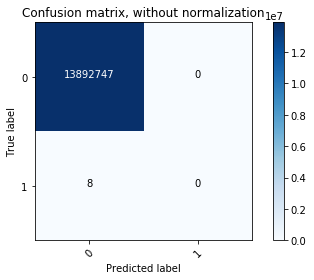

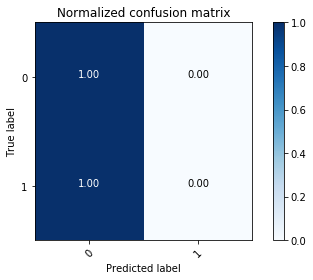

In [106]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ['0','1']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

# Combine Data

This section I tried transforming the dataframes into pandas dataframes. This works, sort of, but it is very slow.

# Create Classification model

In [ ]:
cv = StratifiedKFold(n_splits=6)
classifier = xgb.XGBClassifier()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('round ',i+1)
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()